# Logistic regression

## Imports and custom functions

First, we import libraries, arrays and list we are going to use for this section.

We also redefine a custom function `display_classification_reports_confusion_matrices()` used after GridSearch to display classification report and confusion matrix overall, but also by customer class to assess predictive power for each customer class. `custom_format()` is used to reformat grid_search results and improve readability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import time
import pickle

from IPython.display import display
from itertools import cycle
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             average_precision_score,
                             classification_report,
                             ConfusionMatrixDisplay,
                             f1_score,
                             make_scorer,
                             precision_score,
                             recall_score)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

In [2]:
def display_classification_reports_confusion_matrices(y_pred):
    """
    Takes predictions array as input and display classificaiton report overall and then
    Confusion matrices by customer class (rfm_label) that has been previously one hot encoded
    """
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(wspace=0.8)

    # Plots standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    disp1 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, ax=ax1)
    disp1.ax_.set_xticklabels(class_names, rotation=90)
    disp1.im_.colorbar.remove()

    # Plots normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    disp2 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize="true", display_labels=class_names, ax=ax2)
    disp2.ax_.set_xticklabels(class_names, rotation=90)
    disp2.im_.colorbar.remove()

    # Get classification report
    print(classification_report(y_test, y_pred, output_dict=False, zero_division=1))
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    # Get precision, recall, f1 from report dict
    precision = round(report['weighted avg']['precision'], 2)
    recall = round(report['weighted avg']['recall'], 2)
    f1 = round(report['weighted avg']['f1-score'], 2)
    
    # Format title
    title_formatted = f"Overall Confusion Matrices\nprecision={precision} recall={recall} f1={f1}"
    
    fig.suptitle(title_formatted, y=1.005)
    plt.show()
    
    # OHE columns matching our rfm_labels
    labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

    # Find column indices corresponding to OHE rfm_label columns
    label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

    # Iterate over each OHE rfm_label
    for i, label in enumerate(labels_of_interest):    
        # Find column position of OHE rfm_label
        label_index = label_indices[i]

        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)

        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        
        # Select corresponding rows of y_test and y_pred
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        # Restrict our class_names to only classes in subset
        # VIP can only become 5 values, other 6.
        classes = np.unique(y_test_subset)
        class_names_subset = [class_names[label] for label in classes if label in class_labels]

        fig, axs = plt.subplots(1, 2, figsize=(9, 4))

        # Plots standard confusion matrix
        axs[0].set_title("Confusion Matrix (counts)")
        disp1 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, display_labels=class_names_subset, ax=axs[0])
        disp1.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp1.im_.colorbar.remove()

        # Plots normalized confusion matrix
        axs[1].set_title("Confusion Matrix (ratios)")
        disp2 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, normalize="true", display_labels=class_names_subset, ax=axs[1])
        disp2.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp2.im_.colorbar.remove()

        # Get classification report
        report = classification_report(y_test_subset, y_pred_subset, output_dict=True, zero_division=1)
        # Get precision, recall, f1 from report dict
        precision = round(report['weighted avg']['precision'], 2)
        recall = round(report['weighted avg']['recall'], 2)
        f1 = round(report['weighted avg']['f1-score'], 2)
        # Format title
        title_formatted = f"{label}\nprecision={precision} recall={recall} f1={f1}"
        
        # Set figure title to label of interest
        fig.subplots_adjust(wspace=0.8)
        fig.suptitle(title_formatted, y=1.005)
        plt.show()

In [3]:
# Custom formatting for cv_results
def custom_format(value, col_name):
    if col_name.startswith('param_'):
        return value
    elif 'time' in col_name:
        return round(value, 0)
    elif 'mean' in col_name:
        return round(value, 3)
    elif 'std' in col_name:
        return round(value, 4)
    else:
        return value

Now, we load train and test set and also outliers arrays that can be used in outlier removal.

In [4]:
class_labels = [0, 1, 2, 3, 4]
class_names = ['Sleeping Dog', 'Low Value Customers', 'Sleeping Beauty', 'Good Customers', 'VIP']
colors = ['red', 'orange', 'purple', 'blue', 'green']

# Load test set from pickle file
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
X_test, y_test = testset['X_test'], testset['y_test']

# Load train set from pickle file
with open('trainset_base.pkl', 'rb') as f:
    trainset = pickle.load(f)
X_train, y_train = trainset['X_train'], trainset['y_train']

with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
    
# Load dictionary containing all outliers array
with open("outliers.pkl", "rb") as f:
    loaded_outliers_dict = pickle.load(f)

In [5]:
X_train_outliers_conservative = loaded_outliers_dict["conservative"]
X_train_outliers_aggressive = loaded_outliers_dict["aggressive"]
X_train_outliers_lof = loaded_outliers_dict["lof"]
X_train_outliers_iforest = loaded_outliers_dict["iforest"]

outlier_dict = {
    "conservative": X_train_outliers_conservative,
    "aggressive": X_train_outliers_aggressive,
    "lof": X_train_outliers_lof,
    "iforest": X_train_outliers_iforest
}

In [6]:
model_file_name = 'LogisticRegression.csv'

In [7]:
X_train.shape

(63700, 83)

Here is our machine learning plan from proposal

## Plan

Model interpretability, suitability, scalability, diversity, …?
- __Interpretability__: Logistic Regression is a relatively simple and interpretable model. The model coefficients can provide insights into the relationship between the features and the target variable (it is the classification equivalent of Linear Regression).
- __Suitability__: Logistic Regression is well-suited for multiclass classification tasks. Their linear treatment of all features allows them to extrapolate beyond the values seen during training (from [course](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/decision-trees-and-svms-v4/units/different-model-families-v2))
- __Scalability__: From initial tests, we have seen that Logistic regression scales relatively well with our dataset size.
- __Diversity/Robustness__: By incorporating regularization, Logistic Regression can be made more robust to outliers and noise. Still Logistic Regression would benefit from feature engineering that increase how normally distributed our features are.

Methodologies to be used to train and finetune my models?

- We will use scikit-learn's GridSearchCV to find the best hyperparameters. The grid search involves an exhaustive search through a specified parameter grid and evaluates the model with cross-validation to find the best combination of hyperparameters. It will return both validation score and train score with return_train_score=True and this can be use to assess overfitting, as well as score on unseen test data. 

Model Parameters
- We will try both the one-vs.-rest (OvR) strategy and the softmax regression model. OvR with __solver__ liblinear and Softmax or Multinomial with solver saga (Stochastic Average Gradient Descent with an Adaptive learning rate). [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- __$C$ parameter__ in both cases, $C$ is the inverse of the regularization strength (smaller values indicate stronger regularization). Regularization helps in fitting overfitting as it penalizes stronger coefficients.
- We will try both __penalties l1 and l2__ : the penalty hyperparameter determines the type of regularization applied to the model. l1 indicates L1 regularization (Lasso) and l2 indicates L2 regularization (Ridge). L1 regularization tends to produce sparse models, while L2 regularization encourages the model to distribute weights more evenly across features. 
- __Scaler__: We may also integrate different scalers into our pipeline, same as KNN.
- __PCA__: We will try with and without PCA to reduce dimensionality of our dataset.

## Adaptations based on observations after running model

We simplify the following as we have seen better perfomance
- __scalers__ : we have seen better performance using scaling than no scaling. We use RobustScaler as all our features are not normally distributed.
- __PCA__ : we have seen better perfomance without using PCA in pipeline
- We keep trying both solver, both regularization techniques and will fine tune $C$ on later section.

In [8]:
# Create a list of scalers
scalers = [RobustScaler()]

# Define hyperparameter grid with penalty and solver options
param_grid = [
    {
        'preprocessor__scaler': scalers,
        'dim_reduction': ['passthrough'],
        'classifier__C': np.logspace(-2, 2, num=4),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear'],
        'classifier__multi_class': ['ovr']
    },
    {
        'preprocessor__scaler': scalers,
        'dim_reduction': ['passthrough'],
        'classifier__C': np.logspace(-2, 2, num=4),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['saga'],
        'classifier__multi_class': ['multinomial']
    }
]

# Create pipeline
pipe = Pipeline([
    ('preprocessor', ColumnTransformer(transformers=[
        ('scaler', 'passthrough', list(range(X_train.shape[1]))),
    ])),
    ('dim_reduction', 'passthrough'),
    ('classifier', LogisticRegression(max_iter=1000, tol=1e-3))
])

# Initialize cv_results
cv_results = pd.DataFrame()
best_score = 0
best_params = None
best_outlier_name = None

for outlier_name, outlier_mask in outlier_dict.items():
    print("Removing outliers based on", outlier_name)

    # Remove rows with outliers from X_train and y_train
    X_train_filtered = X_train[outlier_mask != 1]
    y_train_filtered = y_train[outlier_mask != 1]

    # Use GridSearch to find the best parameter
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=3,
        n_jobs=6,
        verbose=1,
        return_train_score=True,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted')
        },
        refit='f1'  
    )

    # Start timer
    start_time = time.time()

    # Fit grid search on training data
    grid_search.fit(X_train_filtered, y_train_filtered)

    # End timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print time taken to fit model
    print("Time taken to fit the model: {:.0f} seconds".format(elapsed_time))

    # Print best parameters found by GridSearchCV
    print("Best parameters found by GridSearchCV:", grid_search.best_params_)

    # Store the best parameters if the score is better than previous best
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_outlier_name = outlier_name
   
    # Evaluation on test data
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))
    
    # Append current cv_results to the overall cv_results dataframe
    current_cv_results = pd.DataFrame(grid_search.cv_results_)
    current_cv_results['param_outliers_removal'] = outlier_name
    cv_results = cv_results.append(current_cv_results, ignore_index=True)

# Reset index of the overall cv_results dataframe
cv_results.reset_index(drop=True, inplace=True)

# Filter X_train and y_train based on best outlier removal method found
best_outlier_mask = outlier_dict[best_outlier_name]
X_train_best = X_train[best_outlier_mask != 1]
y_train_best = y_train[best_outlier_mask != 1]

# Fit best model
pipe.set_params(**best_params)
pipe.fit(X_train_best, y_train_best)

# Evaluation on test data
test_score = pipe.score(X_test, y_test)
print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))

# Assign pipeline to best_model
best_model = pipe

Removing outliers based on conservative
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Time taken to fit the model: 207 seconds
Best parameters found by GridSearchCV: {'classifier__C': 4.6415888336127775, 'classifier__multi_class': 'multinomial', 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'dim_reduction': 'passthrough', 'preprocessor__scaler': RobustScaler()}
Accuracy on unseen test data: 52.49%
Removing outliers based on aggressive
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Time taken to fit the model: 194 seconds
Best parameters found by GridSearchCV: {'classifier__C': 100.0, 'classifier__multi_class': 'multinomial', 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'dim_reduction': 'passthrough', 'preprocessor__scaler': RobustScaler()}
Accuracy on unseen test data: 52.38%
Removing outliers based on lof
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Time taken to fit the model: 178 seconds
Best parameters found by

In [9]:
cv_results = cv_results.sort_values("mean_test_f1", ascending=False)

file_path = os.path.join('gs_results', model_file_name)
cv_results.to_csv(file_path, index=False)

# Get columns starting with 'param_'
param_columns = [col for col in cv_results.columns if col.startswith('param_')]

# Create a list of desired column names
desired_columns = [
    'mean_fit_time',
    'mean_test_f1', 'mean_train_f1',
    *param_columns, 
    'std_test_f1', 'std_train_f1',
    'mean_test_precision', 'mean_train_precision',
    'std_test_precision', 'std_train_precision',
    'mean_test_recall', 'mean_train_recall',
    'std_test_recall', 'std_train_recall',    
]

# Apply custom formatting function and select columns
cv_results = cv_results.apply(lambda col: col.apply(lambda value: custom_format(value, col.name)))
cv_results = cv_results[desired_columns]
cv_results.head(10)

,mean_fit_time,mean_test_f1,mean_train_f1,param_classifier__C,param_classifier__multi_class,param_classifier__penalty,param_classifier__solver,param_dim_reduction,param_preprocessor__scaler,param_outliers_removal,std_test_f1,std_train_f1,mean_test_precision,mean_train_precision,std_test_precision,std_train_precision,mean_test_recall,mean_train_recall,std_test_recall,std_train_recall
44,33.0,0.503,0.507,4.641589,multinomial,l1,saga,passthrough,RobustScaler(),lof,0.0029,0.0005,0.500,0.504,0.0025,0.0004,0.520,0.523,0.0023,0.0009
42,33.0,0.503,0.506,0.215443,multinomial,l1,saga,passthrough,RobustScaler(),lof,0.0027,0.0008,0.500,0.503,0.0025,0.0007,0.520,0.523,0.0022,0.0011
46,33.0,0.503,0.507,100.000000,multinomial,l1,saga,passthrough,RobustScaler(),lof,0.0029,0.0004,0.500,0.504,0.0026,0.0004,0.520,0.523,0.0024,0.0008
47,21.0,0.503,0.507,100.000000,multinomial,l2,saga,passthrough,RobustScaler(),lof,0.0029,0.0004,0.500,0.504,0.0026,0.0004,0.520,0.523,0.0024,0.0008
45,21.0,0.503,0.507,4.641589,multinomial,l2,saga,passthrough,RobustScaler(),lof,0.0029,0.0005,0.500,0.504,0.0026,0.0004,0.520,0.523,0.0024,0.0009
43,18.0,0.502,0.506,0.215443,multinomial,l2,saga,passthrough,RobustScaler(),lof,0.0024,0.0004,0.499,0.503,0.0022,0.0004,0.518,0.523,0.0020,0.0008
63,26.0,0.501,0.505,100.000000,multinomial,l2,saga,passthrough,RobustScaler(),iforest,0.0027,0.0007,0.498,0.502,0.0024,0.0007,0.518,0.522,0.0022,0.0010
62,42.0,0.501,0.505,100.000000,multinomial,l1,saga,passthrough,RobustScaler(),iforest,0.0027,0.0007,0.498,0.502,0.0024,0.0007,0.518,0.522,0.0022,0.0010
61,27.0,0.501,0.505,4.641589,multinomial,l2,saga,passthrough,RobustScaler(),iforest,0.0026,0.0007,0.498,0.502,0.0024,0.0007,0.518,0.522,0.0021,0.0011
60,42.0,0.501,0.505,4.641589,multinomial,l1,saga,passthrough,RobustScaler(),iforest,0.0026,0.0007,0.498,0.502,0.0024,0.0007,0.517,0.522,0.0021,0.0011


## Results

### Classification report and Confusion matrices

We use our custom function to display confusion matrix and classications reports. Note that we don't extensively comment results here as they are from best model on validation f1 weighted score and we might end up chosing a different model with a better trade off between validation f1 weighted score and overfitting. We will do this in our results notebook, where we compile results from all our model.

              precision    recall  f1-score   support

           0       0.59      0.83      0.69      7803
           1       0.45      0.43      0.44      7823
           2       0.41      0.31      0.36      7800
           3       0.41      0.32      0.36      7740
           4       0.66      0.72      0.69      7834

    accuracy                           0.52     39000
   macro avg       0.50      0.52      0.51     39000
weighted avg       0.51      0.52      0.51     39000



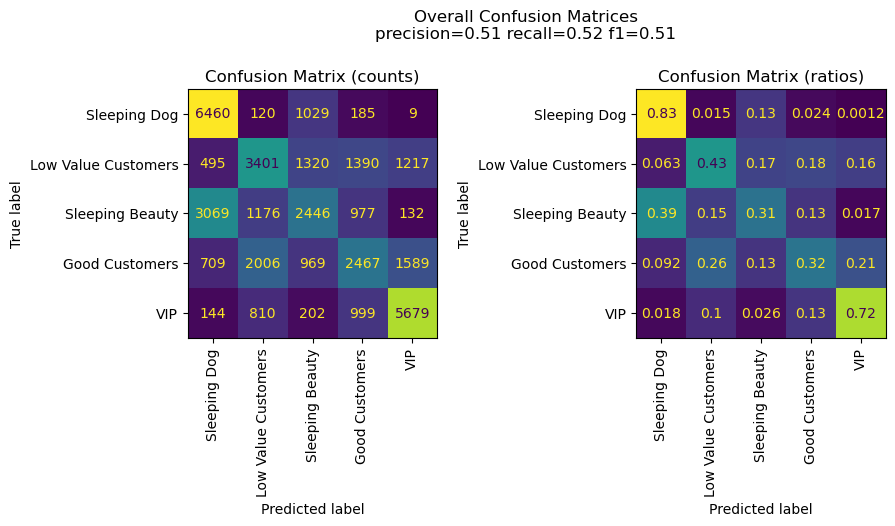

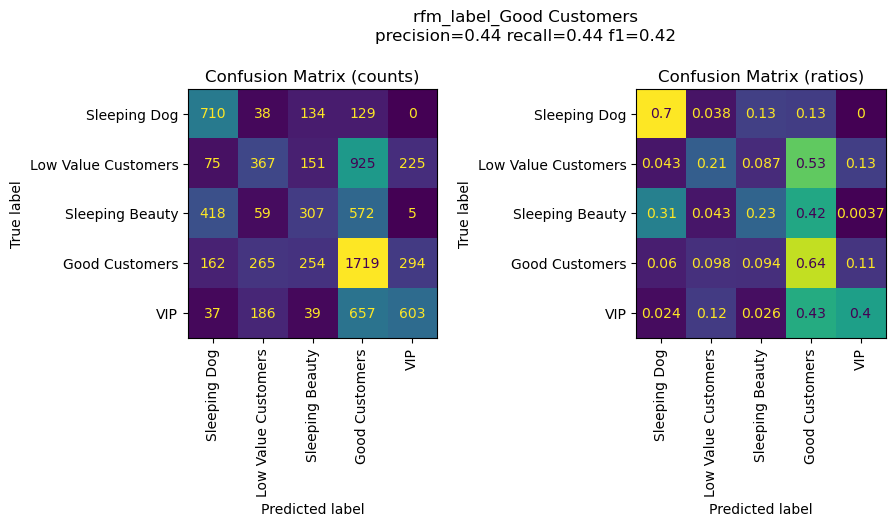

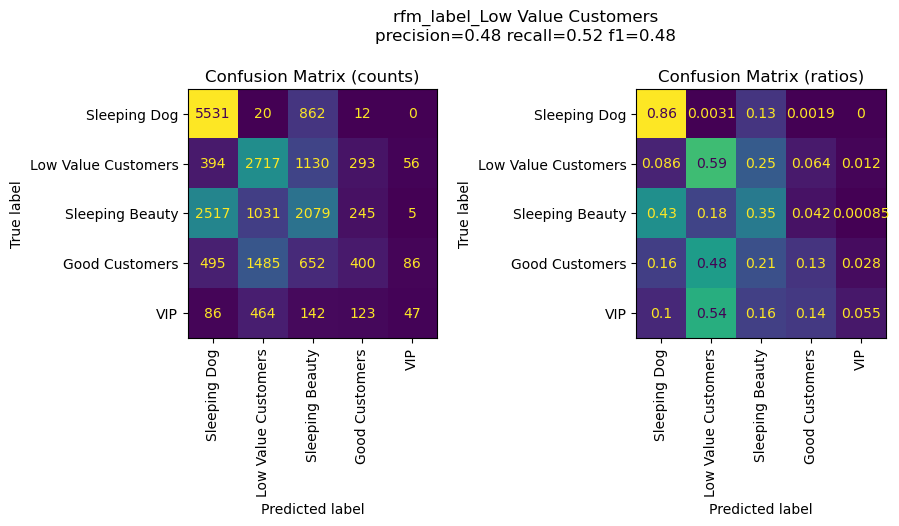

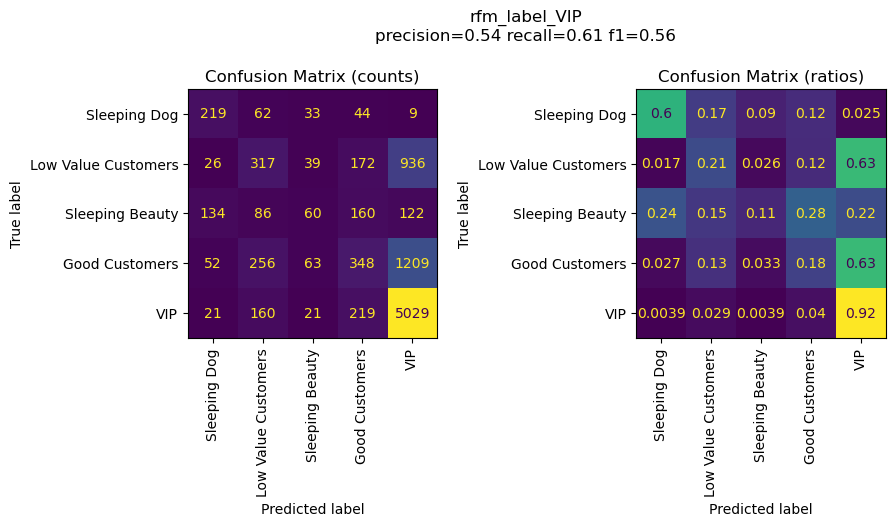

In [10]:
# Predict
y_pred = best_model.predict(X_test)
display_classification_reports_confusion_matrices(y_pred)

## Looking for optimal value of $C$

Based on grid_search results we have seen that
- Classifier perfoms better with RobustScaler than without
- PCA is not useful
- The __combination of multinomial/saga with L2__ is performing best
- Outliers exclusion that shows best performance is aggressive on test data

We retrain using grid_search to search for optimal value of $C$

In [11]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Remove rows with outliers from X_train and y_train
outlier_mask = X_train_outliers_aggressive
X_train_filtered = X_train[outlier_mask != 1]
y_train_filtered = y_train[outlier_mask != 1]

In [13]:
log_reg = LogisticRegression(multi_class='multinomial',
                             penalty='l2',
                             solver='saga',
                             max_iter=1000,
                             tol=1e-3)


param_grid = {
    'C': np.logspace(-4, 4, num=20),
}

grid = GridSearchCV(
    log_reg,
    param_grid=param_grid,
    cv=3,
    n_jobs=6,
    verbose=1,
    return_train_score=True,
    scoring={
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    },
    refit='f1'  
)

# Fit to training
grid.fit(X_train, y_train)

# Print best parameters and corresponding score for training
print("Best parameters: {}".format(grid.best_params_))
print("Training score: {:.2f}".format(grid.best_score_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'C': 0.615848211066026}
Training score: 0.50


In [14]:
cv_results = pd.DataFrame(grid.cv_results_)

columns = [
    "mean_test_f1",
    "std_test_f1",
    "mean_train_f1",
    "std_train_f1",
    "param_C",
]

cv_results = cv_results[columns].sort_values("mean_test_f1", ascending=False)
cv_results.head(5)

,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,param_C
9,0.499105,0.001583,0.502497,0.000359,0.615848
10,0.499092,0.001445,0.502573,0.000258,1.623777
17,0.499072,0.001594,0.502600,0.000219,1438.449888
15,0.499061,0.001596,0.502581,0.000217,206.913808
12,0.499055,0.001581,0.502550,0.000194,11.288379


## Plot the training and validation curves
We chose $C = 0.5$ as overfitting stay quasi null and we could have also chosen 1 or 10. It does not seem to matter as long as we are above $C = 0.1$ 

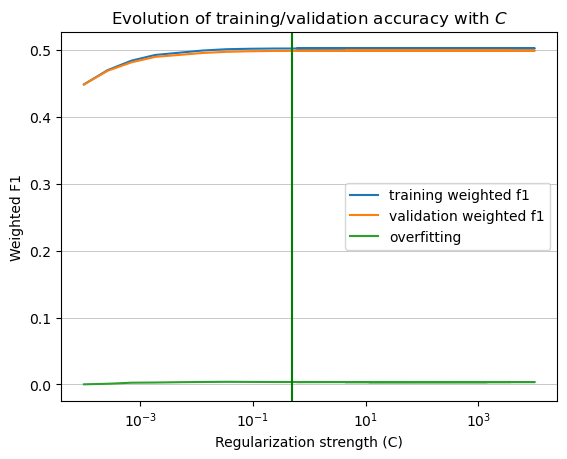

In [15]:
import matplotlib.ticker as ticker

# Calculate the overfitting
overfitting = cv_results["mean_train_f1"] - cv_results["mean_test_f1"]

# Plot training/validation/test accuracy curves
fig, ax = plt.subplots()
ax.semilogx(cv_results["param_C"], cv_results["mean_train_f1"], label='training weighted f1')
ax.semilogx(cv_results["param_C"], cv_results["mean_test_f1"],  label='validation weighted f1')

# Add the overfitting line
ax.semilogx(cv_results["param_C"], overfitting, label='overfitting')

# Add horizontal gridlines with an increment of 0.1
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(axis='y', linewidth=0.5)

ax.set_xlabel('Regularization strength (C)')
ax.set_ylabel('Weighted F1')
ax.axvline(0.5, c='g')

ax.set_title("Evolution of training/validation accuracy with $C$")
ax.legend()
plt.show()